In [55]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

In [3]:
import math

In [4]:
PATH= Path('data/mnist/')

## Reading Data

## Scandir

* Scandir gives us an iterator that we can iterate that will give us the properties of the folder

In [5]:
PATH

PosixPath('data/mnist')

In [6]:
[f.name for f in os.scandir(PATH)]

['.DS_Store', 'train', 'validation']

In [7]:
s = [f.name for f in os.scandir(PATH/"train/1")][0]

In [8]:
[f.name for f in os.scandir(PATH/"train/1")][0]

'10692.png'

In [9]:
s.split(".")

['10692', 'png']

In [10]:
def _get_files(p, fs, extensions = None):
    p = Path(p) # to support / notation
    res = [p/f for f in fs if not f.startswith(".") 
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [11]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e)).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [12]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

data/mnist/train/0
data/mnist/train/1
data/mnist/train/2
data/mnist/train/3
data/mnist/train/4
data/mnist/train/5
data/mnist/train/6
data/mnist/train/7
data/mnist/train/8
data/mnist/train/9


In [13]:
val_x,val_y = create_ds_from_file(PATH/"validation")

data/mnist/validation/0
data/mnist/validation/1
data/mnist/validation/2
data/mnist/validation/3
data/mnist/validation/4
data/mnist/validation/5
data/mnist/validation/6
data/mnist/validation/7
data/mnist/validation/8
data/mnist/validation/9


## Normalization

In general you will normalize your data. It helps our model in learning (explain why in detail)

* Why didn't we normalize independent variables in random forest ? (it also explain why random forests are robust to outliers)

* We will normalize by pixels

* If we had more than 1 channel we would normally normalize by channel so that we would have 1 mean std for Red, 1 mean std for Green, 1 mean std for Blue



* Generally you need specific normalization parameters for each things that you expect to behave differently

* We will normalize validation and test set using the mean and std of training set!

* If we normalize them seperately, it is like pixel value 3 has different meaning when the pixel value is 3 in validation set

In [14]:
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(33.3106), tensor(78.5675), tensor(0.0001), tensor(1.))

In [15]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0061), tensor(1.0077))

## Look at the Data

In [16]:
def show(img, title):
    plt.imshow(img, cmap="gray")
    plt.title(title.item())

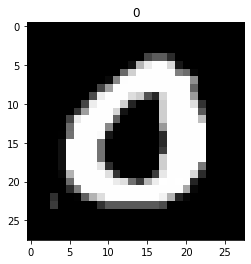

In [17]:
show(trn_x[2].view(28,28), val_y[2])

### View more than one image

* fig.add_subplot(221) means 2x2 grid at subplot 1

* fig.add_subplot(232) means 2x3 grid at subplot 2 etc..

* to make this plot: [link of the code](https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111)
```Python
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(221)   #top left
fig.add_subplot(222)   #top right
fig.add_subplot(223)   #bottom left
fig.add_subplot(224)   #bottom right 
plt.show()
```  

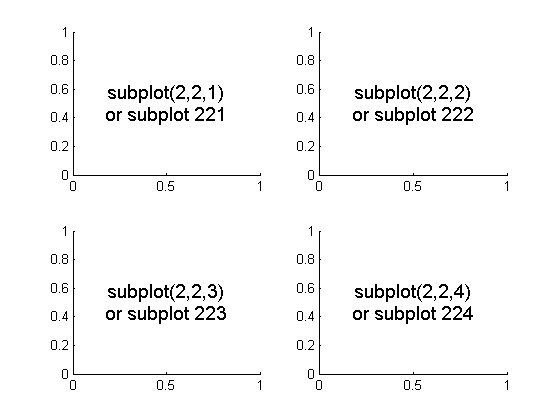

In [18]:
def plots(ims, titles, figsize = (12, 6), rows = 2):
    fig = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    
    for i in range(len(ims)):
        sp = fig.add_subplot(rows, cols, i+1)
        # sp.axis("Off")
        sp.set_title(titles[i].item())
        plt.imshow(ims[i].view(28,28), cmap="gray")

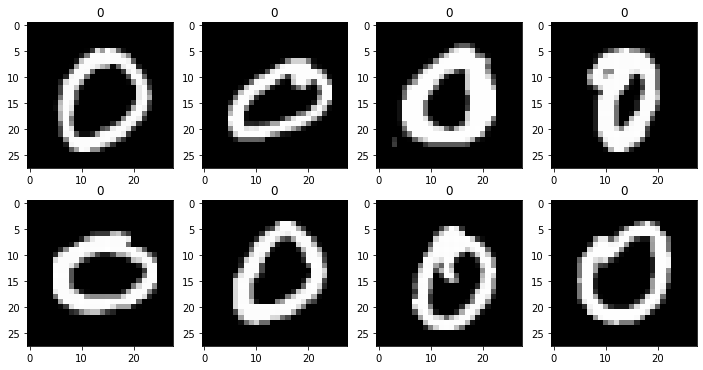

In [19]:
plots(trn_x[:8], titles=val_y[:8])

* You can customize this function and use it for viewing batch

## Dataset and DataLoader

In [72]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i],self.y[i]


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [73]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [74]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

## Softmax

In [75]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

## Negative log likelihood

### Fancy Indexing

In [76]:
predictions = np.random.rand(5,10)

In [77]:
predictions

array([[0.10449072, 0.57120119, 0.0779016 , 0.47232254, 0.56704067,
        0.50361287, 0.59261332, 0.69916697, 0.45133866, 0.25094765],
       [0.96016995, 0.72608029, 0.16645067, 0.95035269, 0.22140461,
        0.14767558, 0.65873206, 0.63984871, 0.77018102, 0.13931737],
       [0.94295995, 0.77617107, 0.32654056, 0.11555546, 0.94920996,
        0.50579622, 0.88249966, 0.6908421 , 0.22743436, 0.22502306],
       [0.03204097, 0.99229359, 0.73426464, 0.96477173, 0.28645151,
        0.28811717, 0.89187023, 0.73424064, 0.97630262, 0.32322352],
       [0.28460272, 0.99282724, 0.34625223, 0.04461369, 0.18054745,
        0.06319401, 0.14546512, 0.10532326, 0.28182569, 0.82447516]])

In [78]:
actuals = np.array([0,3,1,1,9])

In [79]:
actuals

array([0, 3, 1, 1, 9])

In [80]:
predictions.dtype

dtype('float64')

In [81]:
predictions[range(actuals.shape[0]), actuals]

array([0.10449072, 0.95035269, 0.77617107, 0.99229359, 0.82447516])

### nll

* preds[range(actuals.shape[0]), actuals] will give us predictions of true values

In [82]:
def nll(preds, actuals): 
    return -preds[range(actuals.shape[0]), actuals].mean() 

## Accuracy

In [83]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [84]:
def accuracy(preds, yb): 
    return (torch.argmax(preds, dim=1, keepdim = True)==yb).float().mean()

## Training our model

In [85]:
def loss_func(preds, actuals):
    preds = log_softmax(preds)
    return nll(preds, actuals)

In [86]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.squeeze())
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))

In [87]:
model = nn.Sequential(
    nn.Linear(28*28,10)
)

In [88]:
model = nn.Sequential(
    nn.Linear(28*28,60),
    nn.ReLU(),
    nn.Linear(60,10)
)

In [89]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)

In [90]:
train(model,100,10)

0.55859375
0.8690429925918579
0.8968750238418579
0.904003918170929
0.9066406488418579
0.9134765863418579
0.9190429449081421
0.9227539300918579
0.9234374761581421
0.925585925579071


### Overfitting

In [91]:
model = nn.Sequential(
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.Linear(100, 60),
    nn.ReLU(),
    nn.Linear(60,10)
)

In [92]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [93]:
train(model,300,30)

0.564453125
0.9610351324081421
0.9725586175918579
0.9786132574081421
0.979296863079071


KeyboardInterrupt: 

## Regularization

* Why to use Regularization ?

In [94]:
model = nn.Sequential(
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.Linear(100, 60),
    nn.ReLU(),
    nn.Linear(60,10)
)

In [95]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [96]:
train(model,300,30)

0.5464843511581421
0.9598633050918579
0.974902331829071
0.97705078125
0.977832019329071
0.980175793170929
0.9798828363418579
0.979199230670929
0.9803711175918579
0.9805663824081421
